<center>
<h1><em>SPI 2025 SIDECI</em></h1>

# Metric proposal

</center>


The challenge araises from the need to check the adhesion of the prompt in the image generation to the set of keywords from which it was generated. In order to stablish more precise and formally waht's needed, let's consider the full process of generation as follows:

$$ KW_i \xrightarrow[LLM]{} P_i \xrightarrow[GenAI]{Image} IMG_i $$ 

Where:
- $KW_i=\{ keyword_{i,1}:weight_{i,1}, keyword_{i,2}:weight_{i,2}, \dots, keyword_{i,n}:weight_{i,n} \}$ abreviated as $\{k_1:w_1, \dots, k_n:w_n\}$ omitting $i$. From here can be extracted to vectors:
    - $K_i = (k_{i,1}, \dots, k_{i,n})$ the keywords.
    - $W_i = (w_{i,1}, \dots, w_{i,n})$ the weight corresponding to each keyword in the same order.
- $P_i$ is the generated prompt based on the dictionary $KW_i$.
- $IMG_i$ the generated img from $P_i$.

<br>Now that the process is well defined, the problem can be view as create a function $score_i=f(K_{i}, IMG_i)\in\mathbb{R}$, such that *score* measures the quality of waht's been generated.

## **Class Measurement Metric (CMM)**

### **Metric base formulation**

The initial approach will be to measure the accuracy of the image generation based on the percentage of identification of each class on ImageNet compare to the original keywords and its wwights in $KW_i$. For this, the following process is proposed:

$$IMG_i \xrightarrow[Classifier \; \theta]{ImageNet} logits_i \xrightarrow[values]{Class} M_i$$

Where:
- $\theta$ represents the classifier trained on *ImageNet*.
- $logits_i=\theta(IMG_i)$ full raw result tensor from the classifier. From logits the probability can be obtain using *softmax* function.
- $M_i:=(measure_{i,1}, measure_{i,2}, \dots, measure_{i,n})=(m_1, \dots, m_n)$ the corresponding values for each keyword class.

Aditionally, lets consider:

- $\Phi=\{label_1, label_2, \dots, label_n\}$ the set of all available labels.
- $C_i = \{ k_{ij} | k_{ij} \in \Phi \forall i \in [1,n] \}$ the set of used labels for a case given set of keywords.

And the map functions:
- $\phi: \Phi \rightarrow \mathbb{R}$
- $\psi: \mathbb{R} \rightarrow \Phi $

Which allow us to set the expression: $M_{i} = ( logits_{i, \phi(k_{i,j}) } | j \in [1,n] )$ or $M_{ij} = logits_{i, \phi(k_{i,j}) }$.

#### **Measuring keyword combination**

The following ways are proposed:
 - $\uparrow$ $<\hat{W},\hat{M}> = \frac{<W,M>}{ ||W|| \; ||M|| }$ (Cosine similarity $S_C$) 

 - $\downarrow$ $MSE( \hat{W} , \hat{M} ) = \sum_j |\hat{W}_{ij} - \hat{M}_{ij}|^2$

Been $\hat{K},\hat{M}$ are the vectors $K,M$ normalized. Notice that the measurements in $M$ only considers the labels in the keywords set, but ignores the rest predictons, thus, as long as the percentages bewtween the different keywords are held correctly, the score will be good, leading, possibly, to wrong erroneous evaluations. This is reinforced by the normalization as the real value of measurements is lost. This <mark>measures the ratio between terms but ignores class identification score</mark>.

#### **Integrating class scores**

 - The prompt $P_i$ is based on the keydwords in $K_{i}$, so, the probabilities of image class scores output by the classifier should add up close to 1, i.e.:,
 $$\sum_j softmax( logits_i )_{\phi(k_{i,j})} \sim 1$$
  Due to this property, the result of the addition can be taken as a multiplicative factor, the most adhesion to the requested classes the closer the value would be to 1, leading to less alteration of the previous ratio class keyword-prompt measure.

### **Candidates**

#### **First proposal - Multiplicative-CMM ($MCMM$)**

##### *Formulation*

Taking in consideration all the above, the metric proposal is defined as follows:

$$MCMM(K_{i}, IMG_i | \theta) = \underset{W_i \; adhesion (w_a) }{ \underbrace{ <\hat{W}_i,\hat{M}_i> } } \times \underset{C_i \; adhesion (c_a)}{ \underbrace{ \sum_j softmax( logits_i )_{\phi(k_{i,j})} } } $$

where the $M_i, logits_i$ dependency of the metric is omitted as this variables are derived from $IMG_i$. A explict formulation can be writed as:

$$MCMM(K_{i}, IMG_i | \theta) = <\hat{W}_i,\hat{( \theta(IMG_i)_{\phi(k_{i,j}) } | j \in [1,n] )} > \times \sum_j softmax( \; \theta(IMG_i) \; )_{\phi(k_{i,j})}$$

As the cosine similiraty $\in [-1,1]$ and class scores factor is between $[0,1]$, thus, theorically $MCMM \in [-1,1]$ and we will have that the greater the value the better $\uparrow$. For analyzing more precisly, an evaluation of *LHS* and *RHS* of multiplication ($\times$) would be needed, indicating keyword weights $W_i$  and keyword classes  adhesion, respectively.

##### *Interpretability*

- Sign: As the only term that can take negative values is *weight adhesion* $w_a$, the sign of $CCM$ will tell if the quality of the ***HOW***, i.e. if the image is close to the keyword-wieight pairs. $CMM<0$ indicates the ***HOW*** is bad, as for $MCMM>0$ means the opposite, depending, of course, of the value of $CCM$.
- Value: Due to the fact that the metric multiplies $w_a \times c_a$, leaving aside the sign and just taking the value itself will tell no more than "the greater the better", as the independency of $w_a, c_a$ is lost, e.g. $(w_a)0.3 \times (c_a)0.9 \rightarrow 0.27 \leftarrow (w_a)0.9 \times (c_a)0.3$.

> <big>
> <em> Finally, <b>Multiplicative-CMM </b> (MCCM) although been a good theorical metric for evaluating the adhesion, beyond its sign, lacks from a strong interpretability of its value as is not possible to consider a range within in a generation can be consider generally good or bad </em>
></big>

#### **Second proposal - Similarity-CMM (SCMM)**

##### *Formulation*

Addresing the multiplicative problem it is propose to use the same development, until the *multiplicative-ccm*, the new proposal is: Calculate $w_a, c_a \rightarrow$ construct vector $ (w_a, c_a) \rightarrow$ calculate cosine similarity with the ***Perfect fit*** vector $(w_a=1, c_a=1)$, which comes from taking the maximimum possible values from weight and class adhesion. This is expressed as:

$$ SCCM(K_{i}, IMG_i | \theta) = S_C( \: (w_a,c_a), (1,1) \: ) = \left< \;\; \left( <\hat{W}_i,\hat{M}_i> , \sum_j softmax( logits_i )_{\phi(k_{i,j})} \right) \; , (1,1) \;\; \right>$$

$S_C(A,B)\in[-1,1]$ considering that $\measuredangle(A,B)\in[0,2\pi]$, nevertheless, the inputs to $SCCM$ are $(w_a,c_a),(1,1)$ and the angle $\measuredangle( (w_a,c_a),(1,1) )$ is restricted as vector $(w_a, c_a)$ is restricted over the values that its components can take $[-1,1,], \; [0,1]$ respectively, which leads to vetors on a small area inside the $I$ and $II$ quadrants of the plane, and taking into account that $\measuredangle( (1,1) )=\pi/4 \; \Rightarrow \; \measuredangle( (w_a,c_a),(1,1) ) \in [-\pi/4, 3\pi/4]$, and thus, restricting the range to **$SCCM\in[ -\sqrt2/2, 1 ]$**.

##### *Interpretability*

For studying the interpretability let's consider the following diagram:
<center>

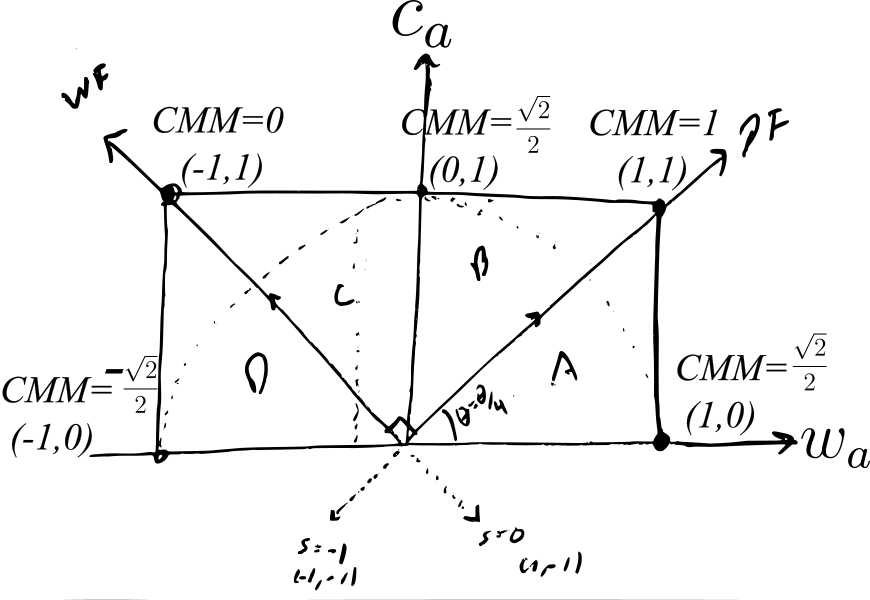
</center>

The rectangle is the boundary all the posible values of the vector $(w_a,c_a)$, all the area inside are valid vector values. $PF$ is the ideal match vector over which all the values lead to $SCMM=1$, on the other hand, $WF$ refers to the **Worst Fit** possible, which lead to $SCMM=0$. Consider these 2 director vecrtors and the y-axis, 4 distinct zones are made, each of which will have different properties in relation of the value of $SCMM$ and its interpretation:

- $A$: $\angle \in [\frac{-\pi}{4},0] \;\; SCMM \in [\frac{\sqrt 2}{2}, 1] $: $w_a, c_a$ are in '*balance*' improving together, the value of one must be greater for the other to increase as well, leading to have <em style="color:green">*WHAT we want AND HOW we want it*</em>.
- $B$: $\angle \in [0,\frac{\pi}{4}] \;\;\; SCMM \in [\frac{\sqrt 2}{2}, 1] $: Same as B, i.e. <em style="color:green">*WHAT we want AND HOW we want it*</em>
- $C$: $\angle \in [\frac{\pi}{4}, \frac{\pi}{2}] \;\;\; SCMM \in [0,\frac{\sqrt 2}{2}] $: In this section we will have that $w_a<0$ meaning that the adhesion *HOW* we want the generation is bad, even when *WHAT* we wanted could be good. $w_a$ and $c_a$ compete against each other to get better, meaning that for one to get better the other must decrease its value, which in time translate to we get <em style="color:yellow">*WHAT we want OR HOW we want it*</em>.
- $D$: $\angle \in [\frac{\pi}{2}, \frac{3\pi}{4}] \;\; SCMM \in [-\frac{\sqrt 2}{2},0] $: Bad result, <em style="color:red">*NOT WHAT we want NOR HOW we want it*</em>

This information is summarized as follows:

<center>

| Zone | What | How |
|------|------|-----|
| **A**| Yes  | Yes |
| **B**| Yes  | Yes |
| **C**| Yes  | No  |
| **D**| No   | No  |
</center>

It is worth to note the meaning of the $WF$ directio which value is $SCCM=-1$. All of the vectors that will produce this output are of the form $(-a,a) a\in [0,1]$ which will mean that the HOW is equally inverse to the WHAT, i.e. the result could be according to the classes but it will generate the opposite of the proportion of we wanted. An example of this could be as follows: {dogs: 80, city:20} -> "dogs in the city" and after evaluation obtain a proportion of identification {dogs: 20, city:80} which translates to the generation to make more emphasis on the city and not in the dogs.

> <big>
> <em> Finally, <b>Similarity-CMM </b> (SCCM) is a <b>better</b> option that its multiplicative counterpart as the its interpretability it's better, telling more about the quality of the results. </em>
></big>


#### **Third proposal - Averaged-CMM (ACMM)**

##### Formulation

As pointed out in the [concluding notes of second tests](#tests-results-notesconclutions), the metric variation $SCMM$ must be modified to be more sensitive to the adhesion values not only to its inner relation. Let's develop a new proposal/variant, for this first let's review the names of previous variables to ease the process:
 - Similitude vector $\overrightarrow{sim}_{wc} = ( w_a, c_a )$ 
 - $\overrightarrow{1} = J_{1,2}= (1,1)$ for the *PF* vector.
 - $SCMM = S_C( \overrightarrow{sim}_{wc}, \overrightarrow{1} )$

The new proposal arises from the last [conclusion](#tests-results-notesconclutions): **scale the metric $SCMM$ by the norm of the similitude vector $\overrightarrow{sim}_{wc}$**:

$$ NewCMM = \left\| \overrightarrow{sim}_{wc} \right\| \times S_C( \overrightarrow{sim}_{wc}, \overrightarrow{1} ) $$

Notice that:

$$ \left\| \overrightarrow{sim}_{wc} \right\| \times S_C( \overrightarrow{sim}_{wc}, \overrightarrow{1} )  = 
\left\| \overrightarrow{sim}_{wc} \right\| cos( \theta_{ \overrightarrow{sim}_{wc}, \overrightarrow{1} } ) = 
component_{ \overrightarrow{1} } \overrightarrow{sim}_{wc}
$$

The new metric is the scalar projection of similitude vector $\overrightarrow{sim}_{wc}$ onto *PF* vector $\overrightarrow{1}$:

$$ NewCMM = component_{ \overrightarrow{1} } \overrightarrow{sim}_{wc} $$

Now let's proceed as follows:

$$
component_{ \overrightarrow{1} } \overrightarrow{sim}_{wc} = 
\left\| \overrightarrow{sim}_{wc} \right\| \times \left < \hat{ \overrightarrow{sim}_{wc}  }, \hat{ \overrightarrow{1} } \right > =
\cancel{\left\| \overrightarrow{sim}_{wc} \right\|} \times
    \frac{ \left < \overrightarrow{sim}_{wc}, \overrightarrow{1} \right > }
    { \cancel{ \left\| \overrightarrow{sim}_{wc} \right\| } \left\| \overrightarrow{1} \right\| } = 
\frac{ \left < \overrightarrow{sim}_{wc}, \overrightarrow{1} \right > }{  \left\| \overrightarrow{1} \right\| } =
\frac{ w_a + c_a }{ \sqrt{2} }
$$

$$
\Rightarrow
NewCMM = \frac{ w_a + c_a }{ \sqrt{2} }
$$ 

For the range of $NewCMM$ it's given by expressionn $-1 \leq w_a + c_a \leq 2$ divided by $\sqrt 2$, thus $NewCMM \in [-1/\sqrt{2}, \sqrt{2}]$. As we would like to have a mx value of $1$, the new metric is redefined as:

$$
NewMetric = \frac{ component_{ \overrightarrow{1} } \overrightarrow{sim}_{wc} }{ \sqrt{2} } = \frac{ w_a + c_a }{ 2 }
$$

Resulting in that ***the new proposal is reduced to be the average of the adhesions, therefore is named Average-CMM ($ACMM$)***. The new range is $ACMM \in [-0.5,1]$


##### *Interpretability*

The interpretation of the avergae tells same as previous the higher the better, the difference and advange over previous $ACMM$ is crystal clear when analyzing the '*line level*' over which tha value of metric helds constant. For this, we will consider some value $s$ that's the measure given by $ACMM$ and lets express $c_a$ in terms of $w_a$:

$$
s= (w_a + c_a)/2 \Rightarrow 2s = w_a + c_a \Rightarrow c_a = -w_a +2s
$$

Being $c_a = -w_a + 2s$ inverse identity funcionts transported across the plane as seeing in the below:

<center>

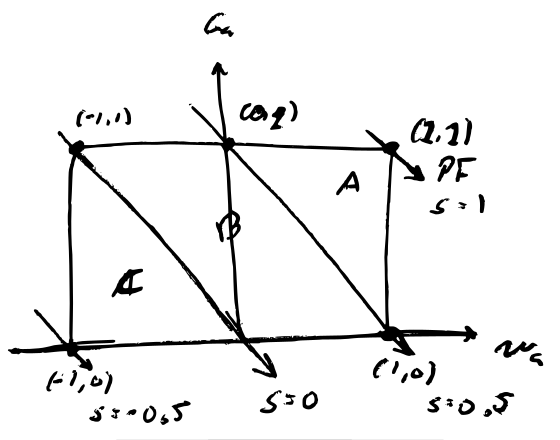
</center>

Now 3 different areas are indicated:
 - $A: \; SCMM \in [0.5,1]$: The '*golden area*', as $w_a, c_a$ improve together, thus, can be said that will be generally good results. <em style="color:green">*WHAT we want AND HOW we want it*</em>
 - $B: \; SCMM \in [0,0.5]$: This zone will have mixed results, as the values for *weight adhesion* can be negative or positive, not a general rule for sign can be given here. What can be said in this region is that $w_a$ and $c_a$ are 'fighting' for getting better, if the more weight adhesion improves the more class adhesion gets worse, and viceversa. <em style="color:yellow">*WHAT we want OR HOW we want it*</em>.
 - $C: \; SCMM \in [-0.5,0]$: As in the previous case, these will be bad results, $w_a$ is always negative and the closer to 0 it is, the quality of classes is worse. This is <em style="color:red">*NOT WHAT we want NOR HOW we want it*</em>.

Summarizing the zones:

 <center>

| Zone | What | How |
|------|------|-----|
| **A**| Yes  | Yes |
| **B**| Yes  | No  |
| **C**| No   | No  |
</center>

Notice that the $WF$ vector/line is mantain fixed between $SCMM$ and $ACMM$ (a consequence of the definition), but if we follow the $PF$ vector from $(0,0) \rightarrow (1,1)$ now the metric value increases, different from the case of $SCMM$ where all the points over the identity gives the same metric value $0$, which was the problem in $SCMM$.

> <big>
> <em> Finally, <b>Average-CMM </b> ($ACCM$) is the <b>best</b> option until this point as its interpretability is more reliable than that of $SCMM$</em>
></big>

### **Dealing with missing class keywords** $k_{ij}\notin \Phi$

It is important to take into account that if some of the concepts/words used for the generation are not in the ImageNet classes, we would be unable to measure the similarity, in order to cope with this problem we propouse the following solution mechanisms:

 - <em style="background-color:rgba(160,160,160,0.4);color:	#FFFF33">word2vec</em>: Search for a similar word $w$ that satisfy $ w \in \Phi$, <em style="background-color:rgba(160,160,160,0.4);color:	#FFFF33">fast but does not capture semantic relation in phrases</em>.
 <br><br>
 - <em style="background-color:rgba(160,160,160,0.4);color:#32CD32">Lenguage Models</em>: Use a small LM that's intended to evaluate similarity, allowing to select the closest class, <em style="background-color:rgba(160,160,160,0.4);color:#32CD32">good results but computationally extensive</em>. The proposal model is *paraphrase-MiniLM-L6-v2*.
 <br><br>
 - <em style="background-color:rgba(160,160,160,0.4);color:#0096FF">Relaxed fitting</em>: Even though $\phi(k_{i,j})$ term in the *RHS* of the metric definition (which checks for adhesion to classes) is originally intended to consider 1 class index per keyword, the mechanism could be modified to accept all the classes that contains the keyword, i.e.:
    - Strict: $ \phi(k_{i,j}) = c_k | c_k \in \Phi \; \wedge \; k_{i,j}==c_k \;\; \phi(k_{i,j}) \in \mathbb{R} $
    - Relaxed: $ \phi(k_{i,j}) = \{ c_k | c_k \in \Phi \; \wedge \; k_{i,j} \subseteq c_k \} \;\; \phi(k_{i,j}) \in \mathbb{R}^{m} $

    To consider both cases the result of compute the hole $k_{ij}$ is considered as a vector, even when is just 1 element. This slightly changes the class adhesion $c_a$ term:

    $$ \sum_j \sum_k [ softmax( logits_i )_{ \phi(k_{i,j}) } ]_k $$

    As well as the expression for $M_i$:

    $$ M_{i} = ( \sum_k (logits_{i, \phi(k_{i,j}) })_k | j \in [1,n] ) $$
    $$ M_{ij} = \sum_k (logits_{i, \phi(k_{i,j}) })_k $$

    While this mechanism could cope with the missing class-keyword problem, raised another:
     - <em style="background-color:rgba(160,160,160,0.4);color:#0096FF">Erroneous class consideration</em>: E.g. $\text{'cat'} \subseteq \text{'cattle'}$ but the words have nothing in common $\xrightarrow[solution]{possible}$ ```\W*{my_kwd}\W*```regex expression checking a new *stand alone word* condition. Though decreasing errors some may be comitted, e.g. $\text{'paper'} \subseteq \text{'paper cut'}$.
<br><br>
 - <em style="background-color:rgba(160,160,160,0.4);color:#FF5F1F ">Relaxed fitting + LM</em>: Filter all clases in $\Phi$ with relaxed fitting and from the resulting classes use the LM for checking the most similar class.

### **ImageNet Classification model selection** $\theta$

Como se formuló, será necesario un modelo de clasificación para ImageNet, para lo cual se hará uso de un modelo preentrenado, seleccionaddo de entre algunos comunmente usados para esta tarea:

<center>

| Modelo              | Variante         | Top-1 Accuracy | Top-5 Accuracy | Parámetros     | FLOPs              |
|---------------------|------------------|----------------|----------------|----------------|--------------------|
| **AlexNet** (2012)  | -                | ~57.2%         | ~80.3%         | ~61M           | ~725M             |
| **VGGNet** (2014)   | VGG16            | ~71.5%         | ~89.8%         | ~138M          | ~15.5G            |
|                     | VGG19            | ~71.8%         | ~90.1%         | ~144M          | ~19.6G            |
| **GoogLeNet** (2014)| Inception V1     | ~69.8%         | ~89.6%         | ~6.8M          | ~1.5G             |
| **ResNet** (2015)   | ResNet-50        | ~76.2%         | ~92.9%         | ~25.6M         | ~4.1G             |
|                     | ResNet-101       | ~77.3%         | ~93.5%         | ~44.5M         | ~7.8G             |
|                     | ResNet-152       | ~78.3%         | ~94.1%         | ~60.2M         | ~11.3G            |
| **DenseNet** (2017) | DenseNet-121     | ~74.9%         | ~92.3%         | ~8M            | ~2.9G             |
|                     | DenseNet-169     | ~76.2%         | ~93.2%         | ~14.2M         | ~3.4G             |
| **EfficientNet** (2019)| EfficientNet-B0| ~77.1%        | ~93.3%         | ~5.3M          | ~0.39G            |
|                     | EfficientNet-B7  | ~84.3%         | ~97.0%         | ~66M           | ~37G              |
| **MobileNet** (2017)| MobileNet-V1     | ~70.6%         | ~89.5%         | ~4.2M          | ~0.57G            |
|                     | MobileNet-V2     | ~72.0%         | ~91.0%         | ~3.4M          | ~0.31G            |
| **Vision Transformer** (2020)| ViT-B/16| ~77.9%         | ~93.9%         | ~86M           | ~17.6G            |
|                     | ViT-L/16         | ~85.3%         | ~97.2%         | ~307M          | ~61.6G            |

</center>

Dados las métricas obtenidas por estos modelso y sus respectivos tamaños y procesamientos, se probará con ***MobileNet*** inicialmente.

### **Testing *MobileNet***

Using model from *hugginface*: https://huggingface.co/learn/computer-vision-course/unit2/cnns/mobilenet

<class 'transformers.models.mobilenet_v2.modeling_mobilenet_v2.MobileNetV2ForImageClassification'>
Predicted class: groenendael
Logits:  6.996652603149414
Probs:  0.3068954050540924


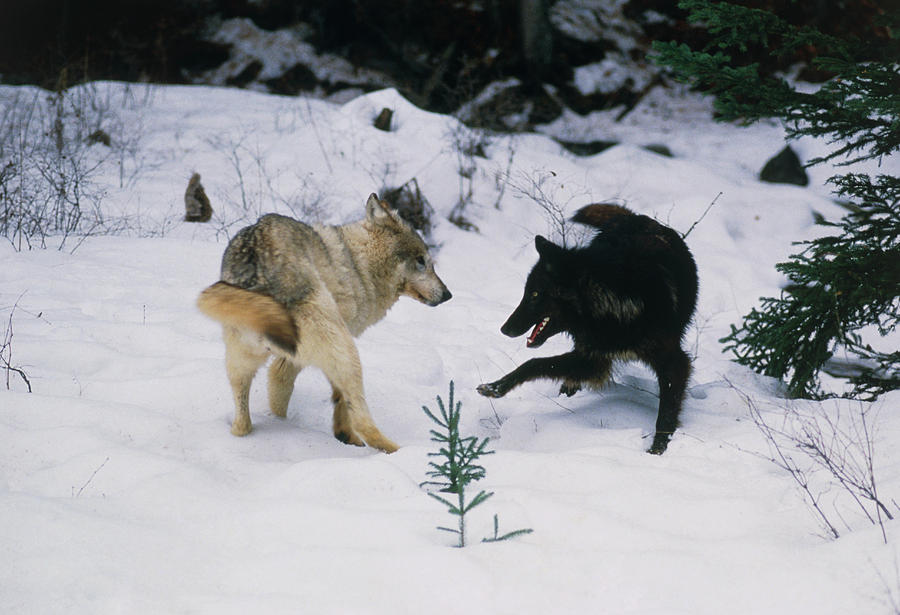

In [3]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
from PIL import Image
import requests

# Cats
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# Wolves
url = "https://images.fineartamerica.com/images-medium-large-5/grey-wolves-playing-william-ervinscience-photo-library.jpg"
# Crowd walking
#url = "https://i1.adis.ws/i/canon/crowd_header_cf3354bb17d643358d6c4719f8d101e0?$hero-header-half-16by9-dt-jpg$"
image = Image.open(requests.get(url, stream=True).raw)

# initialize processor and model
preprocessor = AutoImageProcessor.from_pretrained("google/mobilenet_v2_1.0_224")
model = AutoModelForImageClassification.from_pretrained("google/mobilenet_v2_1.0_224")
print( type(model) )

# preprocess the inputs
inputs = preprocessor(images=image, return_tensors="pt")

# get the output and the class labels
outputs = model(**inputs)
logits = outputs.logits.detach()
probs = torch.softmax(logits, dim=1)

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])
print( "Logits: ", logits[0, predicted_class_idx].item() )
print( "Probs: ", probs[0, predicted_class_idx].item() )

display(image)

Viewing the $n$ first categories:

In [61]:
n = 10

sorted_logits = sorted([ (logits[0,i].item(), i) for i in range(0,logits.shape[1]) ], key=lambda x: x[0], reverse=True)
for i in range( n ):
    idx = sorted_logits[i][1]
    print( f"{i+1}: {model.config.id2label[idx]} \t ({logits[0,idx]}, {probs[0,idx]})" )

print( f"Background class: {logits[0,0]}, {probs[0,0]}" )

1: groenendael 	 (6.996652603149414, 0.3068954050540924)
2: timber wolf, grey wolf, gray wolf, Canis lupus 	 (6.3449554443359375, 0.15994177758693695)
3: red wolf, maned wolf, Canis rufus, Canis niger 	 (5.094829559326172, 0.04581831768155098)
4: coyote, prairie wolf, brush wolf, Canis latrans 	 (4.909599781036377, 0.038071051239967346)
5: white wolf, Arctic wolf, Canis lupus tundrarum 	 (4.129587650299072, 0.017451787367463112)
6: German shepherd, German shepherd dog, German police dog, alsatian 	 (3.8612823486328125, 0.013344933278858662)
7: wild boar, boar, Sus scrofa 	 (3.7338528633117676, 0.01174828503280878)
8: dogsled, dog sled, dog sleigh 	 (3.5768871307373047, 0.010041650384664536)
9: Norwegian elkhound, elkhound 	 (3.2923474311828613, 0.0075549413450062275)
10: schipperke 	 (3.143519639968872, 0.006510225124657154)
Background class: 0.18027380108833313, 0.0003362596617080271


Notice that:
 - ```model.config.label2id.keys()``` $ = \Phi$
 - ```model.config.label2id```: *label* $\rightarrow i \in [0,1000]$, i.e. $\phi$ 
 - ```model.config.id2label```: $i \in [0,1001] \rightarrow$ *label*, i.e. $\psi$ ( extra element is 'cause to 2 different ids ($135, 518$) lead to the same word *crane*, the error is in $phi$ map )
 - ```model().logits``` $= logits_i \in \mathbb{R}^{1\times 1001}$

Some test for the regex expression:

### Tests for filtering classes

#### Regex *stand alone word* condition

In [55]:
import re
kwd = "wolf"

pattern = f".*(^|\s){kwd}($|\s|,).*"
pattern = r".*\b" + kwd + r"\b.*"
test = re.compile(pattern).match("white wolf, a")

print( test if test is not None else "No match" )

<re.Match object; span=(0, 13), match='white wolf, a'>


#### LM filtering

Test for LM class selection using https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2 :

In [81]:
from sentence_transformers import SentenceTransformer
# [kwd, class_1, class_2, etc]
mini_lm = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

In [141]:
kwd = "white wolf"
filter_classes = ["coyote, prairie wolf, brush wolf, Canis latrans",
                "killer whale, killer, orca, grampus, sea wolf, Orcinus orca",
                "red wolf, maned wolf, Canis rufus, Canis niger",
                "timber wolf, grey wolf, gray wolf, Canis lupus",
                "white wolf, Arctic wolf, Canis lupus tundrarum",
                "wolf spider, hunting spider" ]

embs = mini_lm.encode( [kwd] + filter_classes, convert_to_tensor=True)
embs_cosine_sim = mini_lm.similarity( embs[0][None,:], embs[1:] )[0]
for i in range(len(embs_cosine_sim)):
    print( embs_cosine_sim[i], filter_classes[i] )
print( "\nWinner:", filter_classes[ embs_cosine_sim.argmax() ])

tensor(0.5186) coyote, prairie wolf, brush wolf, Canis latrans
tensor(0.3846) killer whale, killer, orca, grampus, sea wolf, Orcinus orca
tensor(0.5786) red wolf, maned wolf, Canis rufus, Canis niger
tensor(0.6263) timber wolf, grey wolf, gray wolf, Canis lupus
tensor(0.6221) white wolf, Arctic wolf, Canis lupus tundrarum
tensor(0.5375) wolf spider, hunting spider

Winner: timber wolf, grey wolf, gray wolf, Canis lupus


It must be noticed that even when the test keyword ```kwd``` is a explicit category in ```filter_classes```, it is not the most similar, maybe due to the repetition of the word *wolf* in the winner class, thus the importance of filter the classes first (here no filtering were done, if did it just the right category would have beed passed).

Still noticing the importance of the filtering, it is worth the test of process all the classes to get the most similar:

In [122]:
kwd = "snow"
all_cls = list(model.config.label2id.keys())
all_embs = torch.Tensor( mini_lm.encode( [kwd] + all_cls) )
all_embs_cosine_sim = torch.nn.CosineSimilarity(dim=1)( all_embs[0][None,:], all_embs[1:] )
print("\t\tTop 10 classes")
for val,i in sorted(zip(l:=all_embs_cosine_sim, range( len(l) ) ), reverse=True)[:10]:
    print( val, all_cls[i] )

		Top 10 classes
tensor(0.7510) ski
tensor(0.7115) snowplow, snowplough
tensor(0.6237) snowmobile
tensor(0.5543) ski mask
tensor(0.4496) trench coat
tensor(0.4157) fur coat
tensor(0.3762) shovel
tensor(0.3683) sock
tensor(0.3591) junco, snowbird
tensor(0.3436) volcano


~ 2segs CPU time is time needed, so, it is worth to taking into consideration the speed of computing the most similar classes. What would happen if we filter the classes first?

In [123]:
all_cls = [c for c in all_cls if kwd in c]
all_embs = torch.Tensor( mini_lm.encode( [kwd] + all_cls) )
all_embs_cosine_sim = torch.nn.CosineSimilarity(dim=1)( all_embs[0][None,:], all_embs[1:] )
for val,i in sorted(zip(l:=all_embs_cosine_sim, range( len(l) ) ), reverse=True):
    print( val, all_cls[i] )

tensor(0.7115) snowplow, snowplough
tensor(0.6237) snowmobile
tensor(0.3591) junco, snowbird
tensor(0.3029) snow leopard, ounce, Panthera uncia


Aside of reducing the execution time to the point as to be perceived as immediate, is important to notice that words that had some relation with the kwd but does not contain the word itself, have gone, as it is the filtering condition (and not even the one that impose the *stand alone word* condition).

> Some remarkable notes of filtering:
>  - LM filtering is slower that standard string, but it is still <u>fast</u>.
>  - Not filtering before using the LM could lead to select a similar class but not the one nedded, e.g. 'white wolf' is a explicit class and LM returns another due to the repetition of word 'wolf' $\Rightarrow$ <u>Filtering could potentially enhance selection</u>
>  - Filter the classes may delete classes that have more relation even when keyword is not contain as a str $\Rightarrow$ <u>Give the option of not to filter classes and select a class or set *n* of classes according to a threshold</u>.

### **Metric tests**

#### **Metric v1 test - *No LM filtering***

In [143]:
from typing import Literal
from __future__ import annotations

import torch, re
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification

def phi_map( k:str, class2id:dict[str:int], background_class:bool=False, strict_fit:bool=False, selection_fn:function=None ) -> list[list[int]]:
    """Returns a list of all the classes for all the keywords.
        Args:
            - k: list of keywords
            - class2id: dictionary to map class->id
            - background_class: When True, empty keyword positions [] will be filled with 0 idx.
            - strict_fit:   If True, no keyword search for substr will be done but exact fit of keywords in class
                            If False, for each kwd all classes that follows: kwd in class_k condition
            - selection_fn: Function that given a keyword an a set of classes, selects a sublist of the orignal.
                            The purpose is to filter all the options"""
    if strict_fit:
        phi_i = [ [ class2id[kwd] ] for kwd in k ]
    else:
        phi_i = [ [ class2id[class_k] for class_k in class2id.keys()
                   if re.compile(f".*(^|\s){kwd}($|\s|,).*").match(class_k)
                   #if kwd in class_k
                   ] for kwd in k ]
    #if selection_fn is not None:
    #    phi_i = [ selection_fn(kwd_j,phi_ij) for kwd_j,phi_ij in zip(k,phi_i) ]
    if background_class:
        phi_i = [ phi_ij if phi_ij!=[] else [0] for phi_ij in phi_i ]
    return phi_i

def get_M( phi_i:list[list[int]], logits:torch.Tensor ) -> torch.Tensor:
    """Returns the m measurents vector"""
    return torch.Tensor([ sum([logits[i].item() for i in phii_j ]) for phii_j in phi_i ])

def cosine_similarity( a:torch.Tensor, b:torch.Tensor ) -> torch.Tensor:
    # Shape (n)
    return sum(a*b)/( a.norm(p=2)*b.norm(p=2) )
# This funtcion is already in torch lol -> torch.nn.CosineSimilarity(dim=0)( a, b )

def calculate_adhesions( kw:dict[str:int], logits_i:torch.Tensor, class2id:list[str] ) -> torch.Tensor:
    """aa"""
    k_i, w_i = zip(*kw.items())
    phi_i = phi_map( k_i, class2id )
    probs_i = torch.softmax( logits_i, dim=0 )
    m_i = get_M( phi_i, logits_i )
    print("w_i: ", w_i)
    print("phi_i: ", phi_i)
    #print("phi_i values: ", [ [logits[i].item() for i in phii_j ] for phii_j in phi_i ])
    print("m_i: ", m_i)
    #weight_adhesion = cosine_similarity( torch.Tensor(w_i), m_i ) # Shape (1,)
    weight_adhesion = torch.nn.CosineSimilarity(dim=0)( torch.Tensor(w_i), m_i ) # Shape (1,)
    class_adhesion = sum([ sum([probs_i[k] for k in phi_ij ]) for phi_ij in phi_i ])
    return (weight_adhesion, class_adhesion)

def mobilenet_cmm( kw:dict[str:int], gen_image:Image.Image, 
                  metric_variant:Literal["multiplicative", "similitude", "both"]="similitude",
                  metric_details:bool=False ) -> torch.Tensor|tuple[torch.Tensor]:
    # Load model
    preprocessor = AutoImageProcessor.from_pretrained("google/mobilenet_v2_1.0_224")
    model = AutoModelForImageClassification.from_pretrained("google/mobilenet_v2_1.0_224")
    # Process
    inputs = preprocessor(images=gen_image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits.detach()[0]
    # Get metric
    w_a, c_a = calculate_adhesions( kw, logits, model.config.label2id )
    if metric_details:
        print("Weight adhesion: ", w_a)
        print("Class adhesion: ", c_a)

    if metric_variant=="multiplicative":
        metric = w_a*c_a
    elif metric_variant=="similitude":
        #metric = cosine_similarity( torch.Tensor( [w_a, c_a] ), torch.Tensor([1,1]) )
        metric = torch.nn.CosineSimilarity(dim=0)( torch.Tensor( [w_a, c_a] ), torch.Tensor([1,1]) )
    elif metric_variant=="both":
        mult = w_a*c_a
        #simi = cosine_similarity( torch.Tensor( [w_a, c_a] ), torch.Tensor([1,1]) )
        simi = torch.nn.CosineSimilarity(dim=0)( torch.Tensor( [w_a, c_a] ), torch.Tensor([1,1]) )
        metric = (mult, simi)
    return metric

Testing the function

In [144]:
import requests 

kw = {"wolf":80, "snow":10}

url = "https://images.fineartamerica.com/images-medium-large-5/grey-wolves-playing-william-ervinscience-photo-library.jpg"
#url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

mcmm, scmm = mobilenet_cmm(kw, image, "both", True)

print( "Results MCMM SCMM: ", mcmm, scmm )

w_i:  (80, 10)
phi_i:  [[273, 149, 272, 270, 271, 78], [290]]
m_i:  tensor([20.5298, -0.5443])
Weight adhesion:  tensor(0.9886)
Class adhesion:  tensor(0.2621)
Results MCMM SCMM:  tensor(0.2591) tensor(0.8647)


In [67]:
for i in [273, 149, 272, 270, 271, 78]:
    print( model.config.id2label[i] )

coyote, prairie wolf, brush wolf, Canis latrans
killer whale, killer, orca, grampus, sea wolf, Orcinus orca
red wolf, maned wolf, Canis rufus, Canis niger
timber wolf, grey wolf, gray wolf, Canis lupus
white wolf, Arctic wolf, Canis lupus tundrarum
wolf spider, hunting spider


> Section note: it will be better to create a class

#### **Metric v2 test- *LM filtering***

In [26]:
from typing import Literal
from __future__ import annotations

import torch, re
import torch.nn as nn
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification
from sentence_transformers import SentenceTransformer

class CMM_MobileNet:
    def __init__(self) -> None:
        self.preprocessor = AutoImageProcessor.from_pretrained("google/mobilenet_v2_1.0_224")
        self.classifier = AutoModelForImageClassification.from_pretrained("google/mobilenet_v2_1.0_224")
        self.class2id:dict[str:int] = self.classifier.config.label2id
        self._cosine_sim = nn.CosineSimilarity( dim=0 )
        # For LM filtering
        self._mini_lm = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
        # For debbuging purposes
        # logtis, phi, m, w_a, c_a 
        self.calc_vals:dict[str:object] = {}

    # Base filters
    base_filters = {
        "all" : lambda k_ij, clss: True,
        "substring" : lambda k_ij, clss: k_ij in clss,
        "subword" : lambda k_ij, clss: re.compile(f".*(^|\s){k_ij}($|\s|,).*").match(clss) is not None
        }

    def show_calc_vals(self):
        print( "phi_class: ", self.calc_vals["phi_class"] )
        print( "phi:\t", self.calc_vals["phi"] )
        print( "m:\t", mm:=self.calc_vals["m"], "\tNormalized: ", mm/mm.norm(p=2) )
        print( "w_a:\t", self.calc_vals["w_a"], "\t\tc_a:\t", self.calc_vals["c_a"] )
        sim_vec = torch.Tensor( [self.calc_vals["w_a"].item(),
                                 self.calc_vals["c_a"].item()],  )
        print( "sim_vect: ", sim_vec, "\tNormalized: ", (sim_vec/sim_vec.norm(p=2)) )
    
    def _semantic_filter(self, kwd:str, classes:list[str], n:int|float) -> list[str]:
        """Selects the most similar words from classes to kwd, according to n (int) higher scores or those above a threshold n(float)"""
        embds = self._mini_lm.encode( [kwd] + classes, convert_to_tensor=True)
        embds_scores = self._mini_lm.similarity( embds[0][None,:], embds[1:] )[0]
        embds_scores = sorted( zip( embds_scores, range( len(embds_scores) ) ), reverse=True)
        if isinstance(n,int):
            filtered_classes = [ classes[i] for _, i in embds_scores[:n] ]
        else:
            filtered_classes = [ classes[i] for score, i in embds_scores if score>=n]
        return filtered_classes

    def phi_map(self, k:str, filter_fn:function=None, semantic_selection:int|float=0, background_class:bool=False ) -> list[list[int]]:
        """
        Returns a list of all the classes for all the keywords.
            Args:
                - k: list of keywords
                - selection_fn: Function that says if a keyword belongs to a class given: selection_fn(keyword, class) -> bool
                                If no function given no filtering will be done but exact fit of keywords in class dictionary.
                - semantic_selection: Tells if semantic class selection will be used in the result of selection_fn, which uses the 
                                        'paraphrase-MiniLM-L6-v2' model to compare the similarity. If int, higher n class are selected,
                                        if float, all classes with a n similarity score or higher.
                - background_class: When True, empty keyword positions [] will be filled with 0 idx.
        """
        # If no filter => the keyword itself is a class => sematic selection has no sense
        assert semantic_selection==False or filter_fn is not None, "If 'semantic_selection' is needed, classes must be selected by 'filter_fn'"

        if filter_fn is None:
            phi_i = [ [ kwd ] for kwd in k ]
        else:
            phi_i = [ [ class_k for class_k in self.class2id.keys() if filter_fn( kwd, class_k ) ]
                     for kwd in k ]
            
        if semantic_selection!=False:
            phi_i = [ self._semantic_filter(kwd_j, phi_ij, semantic_selection )
                     for kwd_j, phi_ij in zip(k,phi_i) ]
        
        self.calc_vals["phi_class"] = phi_i

        phi_i = [ [ self.class2id[clss] for clss in phi_ij ] if phi_ij!=[] else
                    ( [0] if background_class else [] )
                    for phi_ij in phi_i ]
        self.calc_vals["phi"] = phi_i
        return phi_i

    def _calculate_adhesions(self, kw:dict[str:int], logits:torch.Tensor, *phi_args, **phi_kwargs ) -> tuple[torch.Tensor]:
        """
        Calculates Weight and Class adhesion
            - Args:
                - kw: keyword-weight dictionary
                - logits: direct result of classifier model on generated image to evaluate
        """
        k_i, w_i = zip(*kw.items())
        phi_i = self.phi_map( k_i, *phi_args, **phi_kwargs )
        probs_i = torch.softmax( logits, dim=0 )
        m_i = torch.Tensor([ sum([logits[i].item() for i in phii_j ]) for phii_j in phi_i ])
        weight_adhesion = self._cosine_sim( torch.Tensor(w_i), m_i )
        class_adhesion = sum([ sum([probs_i[k] for k in phi_ij ]) for phi_ij in phi_i ])
        self.calc_vals["m"] = m_i
        self.calc_vals["w_a"] = weight_adhesion
        self.calc_vals["c_a"] = class_adhesion
        return (weight_adhesion, class_adhesion)

    def calculate(self, kw:dict[str:int], image:Image.Image,
                metric_variant:Literal["multiplicative", "similitude", "both"]="similitude",
                filter_fn:Literal["all","substring","subword"]|function=None,
                semantic_selection:int|float=0, background_class:bool=False ) -> torch.Tensor|tuple[torch.Tensor]:
        """
        Calculates Class Measure Metric.
            - Args:
                - kw: keyword-weight dictionary
                - image: image to be evaluated
                - metric_variant: Which of the variants of CMM will be returned.
                - filter_fn: Function to select the class(es) for each keyword. Predefined functions are:
                       - all: All classes are acepted.
                       - substring: Checks if keyword is substring of class.
                       - subword: Impose that keyword is a complete and stand alone word in class.
                       If None (default), metric consider that keywords are exact classes from imagenet.
                - semantic_selection: If semantic selection is used to reduced classes when filtered.
                                   If int n classes are selected, when float, classes above threshold.
                - background_class: If there's no fitting class for keyword then a 0 idx will be assign.
            
            - Return: If 'metric_variant'!='both' metric value as tensor, otherwhise, tuple with both values.
        """
        assert metric_variant in ["multiplicative", "similitude", "both"], "Bad metric variant"

        inputs = self.preprocessor(images=image, return_tensors="pt")
        outputs = self.classifier(**inputs)
        logits = outputs.logits.detach()[0]
        self.calc_vals["logits"] = logits
        filter_fn = CMM_MobileNet.base_filters[filter_fn] if type(filter_fn)==str else filter_fn
        w_a, c_a = self._calculate_adhesions( kw, logits, filter_fn , semantic_selection, background_class )
        mcmm = w_a*c_a
        scmm = (w_a+c_a)/torch.sqrt( 2*( w_a**2 + c_a**2 ) )
        #scmm = self._cosine_sim( torch.Tensor( [w_a, c_a] ), torch.Tensor([1,1]) )
        if metric_variant=="multiplicative":
            return mcmm
        elif metric_variant=="similitude":
            return scmm
        return (mcmm, scmm)

Testing CMM class:

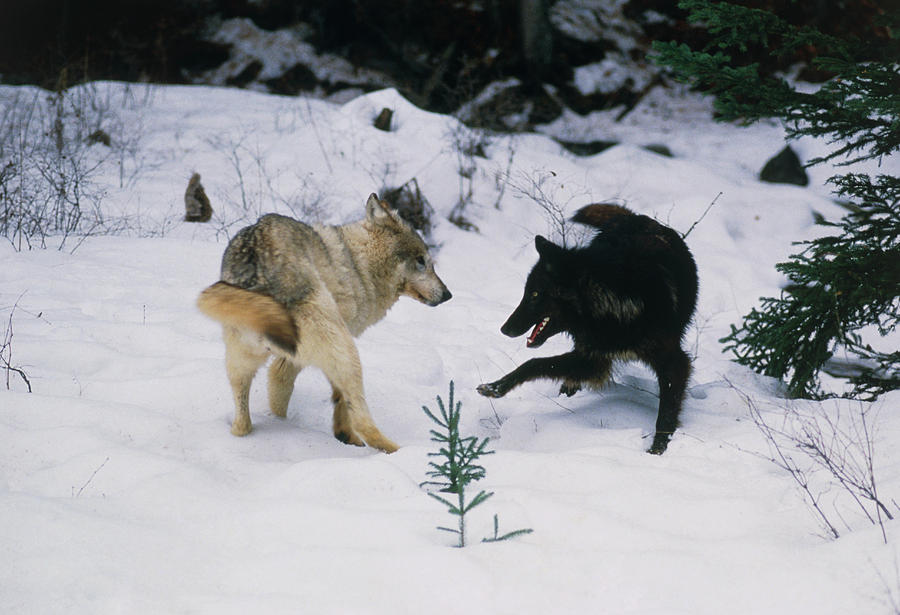

In [3]:
import requests 

url_wolf = "https://images.fineartamerica.com/images-medium-large-5/grey-wolves-playing-william-ervinscience-photo-library.jpg"
img_wolf = Image.open(requests.get(url_wolf, stream=True).raw)
display(img_wolf)

#url_cat = "http://images.cocodataset.org/val2017/000000039769.jpg"
#img_cat = Image.open(requests.get(url_cat, stream=True).raw)
#display(img_cat)

The following tests are intended for checking the efect of:
 - '*substring*' vs '*subword*' filtering.
 - Use semantic selection on filtered class.
 - Use purely semantic selection of classes. i.e. no filtering.
 - Invert keyword weights.
 - Use wrong keywords.

In [27]:
cmm = CMM_MobileNet(  )

In [28]:
kw_1 = {"wolf":60, "snow":10}
kw_2 = {"wolf":10, "snow":60}
kw_3 = {"cat":80, "snowcouch":10}

In [29]:
# '*substring*' vs '*subword*' filtering
strg_m, strg_s = cmm.calculate( kw_1, img_wolf, "both", "substring", False, False )
print( "substring:\t", strg_m, strg_s )
cmm.show_calc_vals()

word_m, word_s = cmm.calculate( kw_1, img_wolf, "both", "subword", False, False )
print( "\nsubword:\t", word_m, word_s )
cmm.show_calc_vals()

substring:	 tensor(0.2674) tensor(0.8674)
phi_class:  [['Irish wolfhound', 'borzoi, Russian wolfhound', 'coyote, prairie wolf, brush wolf, Canis latrans', 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca', 'red wolf, maned wolf, Canis rufus, Canis niger', 'timber wolf, grey wolf, gray wolf, Canis lupus', 'white wolf, Arctic wolf, Canis lupus tundrarum', 'wolf spider, hunting spider'], ['junco, snowbird', 'snow leopard, ounce, Panthera uncia', 'snowmobile', 'snowplow, snowplough']]
phi:	 [[171, 170, 273, 149, 272, 270, 271, 78], [14, 290, 803, 804]]
m:	 tensor([24.8305,  1.3262]) 	Normalized:  tensor([0.9986, 0.0533])
w_a:	 tensor(0.9938) 		c_a:	 tensor(0.2691)
sim_vect:  tensor([0.9938, 0.2691]) 	Normalized:  tensor([0.9652, 0.2614])

subword:	 tensor(0.2573) tensor(0.8656)
phi_class:  [['coyote, prairie wolf, brush wolf, Canis latrans', 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca', 'red wolf, maned wolf, Canis rufus, Canis niger', 'timber wolf, grey wolf, 

> - As logical, ```subword``` restriction apply a more fine filter, thus reducing the classes for each keyword.
> - The reduction of classes does not have an heavy effect as expected, this could be due to the **general low scores obtained by the classes** therefore getting rid of some classes does not have a  great impact.
> - **$w_a, c_a$ <u>shows a good correlation to its base formulation develop</u>** in the [MCMM section](#first-proposal---multiplicative-cmm).
> - **$SCMM$ <u>does not show a good relation to the value of</u> $c_a$** as the metric score is high even when the class adhesion is low.

In [30]:
# semantic
sematic_n = 1

strg_m, strg_s = cmm.calculate( kw_1, img_wolf, "both", "substring", sematic_n, False )
print( "substring:\t", strg_m, strg_s )
cmm.show_calc_vals()

word_m, word_s = cmm.calculate( kw_1, img_wolf, "both", "subword", sematic_n, False )
print( "\nsubword:\t", word_m, word_s )
cmm.show_calc_vals()

substring:	 tensor(0.1604) tensor(0.8104)
phi_class:  [['timber wolf, grey wolf, gray wolf, Canis lupus'], ['snowplow, snowplough']]
phi:	 [[270], [804]]
m:	 tensor([6.3450, 0.7563]) 	Normalized:  tensor([0.9930, 0.1184])
w_a:	 tensor(0.9989) 		c_a:	 tensor(0.1605)
sim_vect:  tensor([0.9989, 0.1605]) 	Normalized:  tensor([0.9873, 0.1587])

subword:	 tensor(0.1551) tensor(0.8129)
phi_class:  [['timber wolf, grey wolf, gray wolf, Canis lupus'], ['snow leopard, ounce, Panthera uncia']]
phi:	 [[270], [290]]
m:	 tensor([ 6.3450, -0.5443]) 	Normalized:  tensor([ 0.9963, -0.0855])
w_a:	 tensor(0.9687) 		c_a:	 tensor(0.1601)
sim_vect:  tensor([0.9687, 0.1601]) 	Normalized:  tensor([0.9866, 0.1631])


> - The **effect is greater on substring filtering** compare when not using smenantic reudction, as in that case considers substantially more classes.
> - Applying ```subword + semantic_selection``` leads to worse keyword scores in $\phi_ij$
> - <u>**$MCMM$ is greatly affected by the finer filter as opposite to $SCMM$**, this is beacuse of the low effect of $c_a$ in $SCMM$</u>

In [33]:
# full semantic
sematic_n = 1

strg_m, strg_s = cmm.calculate( {"wolf":60, "snow":40}, img_wolf, "both", "all", sematic_n, False )
#strg_m, strg_s = cmm.calculate( kw_1, img_wolf, "both", "all", sematic_n, False )
print( "substring:\t", strg_m, strg_s )
cmm.show_calc_vals()

substring:	 tensor(0.1481) tensor(0.8183)
phi_class:  [['timber wolf, grey wolf, gray wolf, Canis lupus'], ['ski']]
phi:	 [[270], [796]]
m:	 tensor([6.3450, 1.1982]) 	Normalized:  tensor([0.9826, 0.1856])
w_a:	 tensor(0.9205) 		c_a:	 tensor(0.1609)
sim_vect:  tensor([0.9205, 0.1609]) 	Normalized:  tensor([0.9851, 0.1722])


> - Even whem similitude vector change, its <u>**normalized version stays very close**</u> to the one got in previous tests, and as we are using cosine similitude consequently the value of $SCMM$ is, again, almost no significatively affected $\Rightarrow$ <mark>**No normalized similitude vector needs to be considered**</mark>.
> - **Full semantic selection successfully takes more similar classes**, e.g. ```ski``` vs ```snow leopard``` or ```snowplug```.

In [34]:
# Invert keyword weights
strg_m, strg_s = cmm.calculate( kw_2, img_wolf, "both", "substring", False, False )
print( "substring:\t", strg_m, strg_s )
cmm.show_calc_vals()

word_m, word_s = cmm.calculate( kw_2, img_wolf, "both", "subword", False, False )
print( "\nsubword:\t", word_m, word_s )
cmm.show_calc_vals()

substring:	 tensor(0.0583) tensor(0.9942)
phi_class:  [['Irish wolfhound', 'borzoi, Russian wolfhound', 'coyote, prairie wolf, brush wolf, Canis latrans', 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca', 'red wolf, maned wolf, Canis rufus, Canis niger', 'timber wolf, grey wolf, gray wolf, Canis lupus', 'white wolf, Arctic wolf, Canis lupus tundrarum', 'wolf spider, hunting spider'], ['junco, snowbird', 'snow leopard, ounce, Panthera uncia', 'snowmobile', 'snowplow, snowplough']]
phi:	 [[171, 170, 273, 149, 272, 270, 271, 78], [14, 290, 803, 804]]
m:	 tensor([24.8305,  1.3262]) 	Normalized:  tensor([0.9986, 0.0533])
w_a:	 tensor(0.2168) 		c_a:	 tensor(0.2691)
sim_vect:  tensor([0.2168, 0.2691]) 	Normalized:  tensor([0.6273, 0.7788])

subword:	 tensor(0.0362) tensor(0.9553)
phi_class:  [['coyote, prairie wolf, brush wolf, Canis latrans', 'killer whale, killer, orca, grampus, sea wolf, Orcinus orca', 'red wolf, maned wolf, Canis rufus, Canis niger', 'timber wolf, grey wolf, 

> - **$w_a$ successfully reflects the relation between weight and the class identification level**
> - $MCMM$ reflects the decrease in $w_a$, showing a decreasing as well.
> - As $w_a$ gets closer to $c_a$, the similitude vector reduce its angle to *PF* vector (check [2nd similitude justification](#second-proposal---similarity-cmm) ), thus, <em style="color:red">increasing</em> $SCMM$. As can be deduced from its definition **$SCMM$ <mark>ignores quality as a whole and just considers the peformance relation between</mark> $w_a,c_a$**, i.e both perfom good, bad, $w_a$ good and $c_a$ bad, etc.

In [35]:
# Use wrong keywords
strg_m, strg_s = cmm.calculate( kw_3, img_wolf, "both", "substring", False, False )
print( "substring:\t", strg_m, strg_s )
cmm.show_calc_vals()

word_m, word_s = cmm.calculate( kw_3, img_wolf, "both", "subword", False, False )
print( "\nsubword:\t", word_m, word_s )
cmm.show_calc_vals()

substring:	 tensor(-0.0034) tensor(-0.7047)
phi_class:  [['Egyptian cat', 'Madagascar cat, ring-tailed lemur, Lemur catta', 'Persian cat', 'Siamese cat, Siamese', 'bullfrog, Rana catesbeiana', 'catamaran', 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens', 'lynx, catamount', 'oscilloscope, scope, cathode-ray oscilloscope, CRO', 'oystercatcher, oyster catcher', 'polecat, fitch, foulmart, foumart, Mustela putorius', 'skunk, polecat, wood pussy', 'sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita', 'tabby, tabby cat', 'tiger cat'], []]
phi:	 [[286, 384, 284, 285, 31, 485, 287, 388, 288, 689, 144, 359, 362, 90, 282, 283], []]
m:	 tensor([-7.8892,  0.0000]) 	Normalized:  tensor([-1.,  0.])
w_a:	 tensor(-0.9923) 		c_a:	 tensor(0.0034)
sim_vect:  tensor([-0.9923,  0.0034]) 	Normalized:  tensor([-1.0000,  0.0034])

subword:	 tensor(-0.0010) tensor(-0.7064)
phi_class:  [['Egyptian cat', 'M

> - **$c_a$ successfully reflects the relation between class wanted and classes classsified**
> - In this extreme test case both variant $MCMM, SCMM$ reflects the bad result.

> ##### **Tests results notes/conclutions**
> - $w_a, c_a$ completely relfects the concepts they were designed for: *weight and classes adhesion* of generation, respectively.
> - Recommended filter + semantic combination is: ```substr + semantic_selection```, ```subword```, ```all + semantic_selection``` (Full semantic selection successfully takes more similar classes).
> - $MCMM$ reflects the changes in $w_a, c_a$.
> - $SCMM$ shows a low capacity of reflects changes in $w_a, c_a$, except from the extreme cases where result has absolutely no relation with keywords. This means that although the variation does reflects the relation, it must be modified to address this changes whith more precision.
> - $SCMM$ ignores quality as a whole and just considers the peformance relation between $w_a,c_a \; \Rightarrow$ To consider overall quality the **<u>similitude vector norm must be conider</u>**.
> - Normalizing similitude vector substracts the effect in $SCMM$ performance, problem that's in the core definition of $SCMM$ due to the use of cosine similitude $\Rightarrow$ **<u>Scale cosine smilitude by the norm of similitude vector?</u>**

The <u>underlined</u> texts are possible solutions to the problems found in the tests.